## Prepare Soil Moisture

In this notebook, monthly averaged ERA5-Land volumetric soil water data from 1981 - 2025 is processed. 
The following variables are processed:
- Volumetric soil water layer 1: 0 - 7 cm
- Volumetric soil water layer 2: 7 - 28 cm
- Volumetric soil water layer 3: 28 - 100 cm
- Volumetric soil water layer 4: 100 - 289 cm

The following steps are included:
- Crop data to Germany
- Crop to forest area
- Save datasets for needleleaved and broadleaved forests

In [1]:
# import libraries
import os
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rioxr
import geopandas as gpd
import odc.stac
import rasterio
import warnings

In [2]:
# set working directory
os.chdir("E:/Master/Thesis/3_Data")
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: E:\Master\Thesis\3_Data


In [3]:
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [4]:
# open dataset
era5 = xr.open_dataset("./Raw/ERA5-Land/data_0.nc", decode_coords="all",decode_times=True)

In [5]:
era5

<xarray.Dataset>
Dimensions:     (valid_time: 528, latitude: 83, longitude: 98)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 1981-01-01 1981-02-01 ... 2024-12-01
  * latitude    (latitude) float64 55.2 55.1 55.0 54.9 ... 47.3 47.2 47.1 47.0
  * longitude   (longitude) float64 5.45 5.55 5.65 5.75 ... 14.95 15.05 15.15
Data variables:
    number      int64 ...
    expver      (valid_time) object ...
    swvl1       (valid_time, latitude, longitude) float32 ...
    swvl2       (valid_time, latitude, longitude) float32 ...
    swvl3       (valid_time, latitude, longitude) float32 ...
    swvl4       (valid_time, latitude, longitude) float32 ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [6]:
# rename dimensions to fit other data
era5 = era5.rename({"valid_time":"time",
                            "longitude": "lon",
                            "latitude": "lat"})

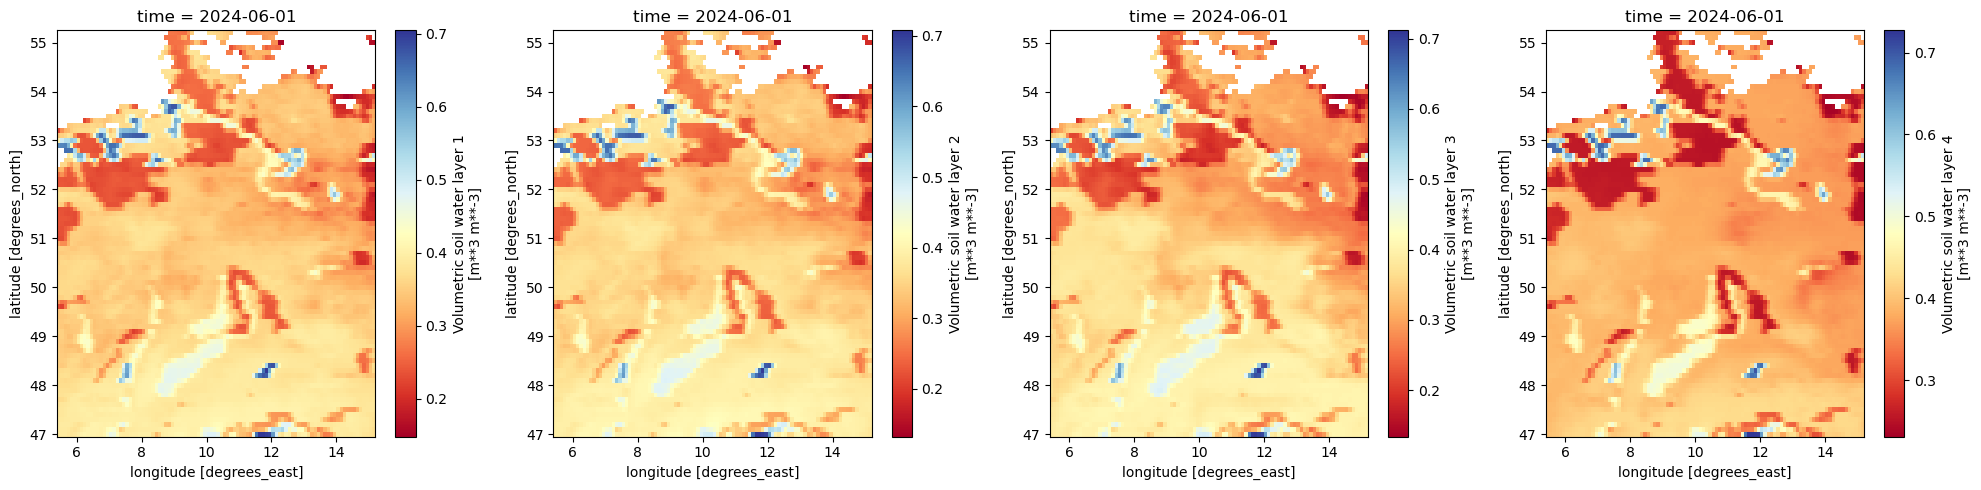

In [7]:
# plot exemplary data of one month to get a first impression
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
era5.swvl1.sel(time='2024-06-01').plot(ax=axs[0], cmap='RdYlBu')
era5.swvl2.sel(time='2024-06-01').plot(ax=axs[1], cmap='RdYlBu')
era5.swvl3.sel(time='2024-06-01').plot(ax=axs[2], cmap='RdYlBu')
era5.swvl4.sel(time='2024-06-01').plot(ax=axs[3], cmap='RdYlBu')
plt.tight_layout()

In [8]:
# check crs
era5.rio.crs

In [9]:
# assign crs to data
era5 = era5.rio.write_crs('WGS 1984')

In [10]:
# load Germany shapefile 
ger = gpd.read_file("./GER.shp")

In [11]:
# check if crs matches data
ger.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [12]:
# extract one date to create mask of germany with dimensions of climate data
era5_ex = era5.swvl1.sel(time = "1981-08-01", method = "nearest")

In [13]:
# create mask of research area using the dimensions of the exemplary climate data
ger_mask = rasterio.features.geometry_mask(ger.geometry, 
                                            out_shape=era5_ex.odc.geobox.shape,
                                            transform=era5_ex.odc.geobox.affine,
                                            all_touched=False,
                                            invert=False)

In [14]:
ger_mask = xr.DataArray(ger_mask, dims=("lat", "lon"))

In [15]:
# create loop to process each soil water layer and each year seperately
# create list of variables to process
vars = ("swvl1", "swvl2", "swvl3", "swvl4")

# also create list of folders to save new datasets in
folders = ("Soil_Water_1", "Soil_Water_2", "Soil_Water_3", "Soil_Water_4")

In [16]:
for v in range(len(vars)):

    # extract soil water layer as xarray
    variable = vars[v]
    folder = folders[v]
    swv = era5[variable]

    # loop over years to process soil water volume per year
    for year in range(1981, 2025):
    
        # select all monthly data within this year
        swv_yearly = swv.sel(time = swv.time.dt.year.isin(year))

        # apply mask of research area to dataset
        swv_ger = swv_yearly.where(~ger_mask)

        # load forest area from ESA Landcover data for corresponding year
        # attention: forest data only available for 1992 - 2022 -> choose 1992 for climate data of 1988-1992
        # and 2022 for climate data of 2022-2024
        if year <= 1992:
            forest_year = 1992
        elif year >= 2022:
            forest_year = 2022
        else: forest_year = year

        forest = xr.open_dataset(f"./Forest_GER/Forest_GER_{forest_year}.nc", 
                                    decode_coords = "all", 
                                    decode_times= True)
        
        # set crs for climate data 
        swv_ger.rio.write_crs(4326, inplace = True)
        
        # set spatial dims - otherwise resampling raises an error
        swv_ger.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace = True)

        # resample climate dataset to match resolution of forest dataset
        swv_match = swv_ger.rio.reproject_match(forest)

        # rename dimensions - they got renamed while resampling
        swv_match = swv_match.rename({'y':'lat', 'x':'lon'})

        # mask with forest data
        # broadleaved forest:
        swv_BL = swv_match.where(forest.lccs_class.sel(time=f"{forest_year}-01-01") == 60, 
                                    drop = False)

        # needleleaved forest:
        NL_mask = forest.lccs_class.sel(time=f"{forest_year}-01-01").isin([70, 80]).compute()
        swv_NL = swv_match.where(NL_mask, drop = False)

        # save as netCDF4 datasets
        swv_BL.to_netcdf(f"./Climate/{folder}/Monthly/{variable}_mon_mean_{year}_BL.nc")
        swv_NL.to_netcdf(f"./Climate/{folder}/Monthly/{variable}_mon_mean_{year}_NL.nc")

In [17]:
# load processed datasets of one year as example and plot to get an overview
swvl1_NL = xr.open_dataarray("./Climate/Soil_Water_1/Monthly/swvl1_mon_mean_2024_NL.nc", decode_coords = "all", decode_times= True)
swvl2_NL = xr.open_dataarray("./Climate/Soil_Water_2/Monthly/swvl2_mon_mean_2024_NL.nc", decode_coords = "all", decode_times= True)
swvl3_NL = xr.open_dataarray("./Climate/Soil_Water_3/Monthly/swvl3_mon_mean_2024_NL.nc", decode_coords = "all", decode_times= True)
swvl4_NL = xr.open_dataarray("./Climate/Soil_Water_4/Monthly/swvl4_mon_mean_2024_NL.nc", decode_coords = "all", decode_times= True)
swvl1_NL

<xarray.DataArray 'swvl1' (time: 12, lat: 2952, lon: 3510)>
[124338240 values with dtype=float32]
Coordinates:
  * lon          (lon) float64 5.451 5.454 5.457 5.46 ... 15.19 15.19 15.2 15.2
  * lat          (lat) float64 55.2 55.2 55.19 55.19 ... 47.01 47.01 47.0 47.0
  * time         (time) datetime64[ns] 2024-01-01 2024-02-01 ... 2024-12-01
    spatial_ref  int32 ...
Attributes: (12/33)
    GRIB_paramId:                             39
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      8134
    GRIB_typeOfLevel:                         depthBelowLandLayer
    GRIB_stepUnits:                           1
    GRIB_stepType:                            avgua
    ...                                       ...
    GRIB_units:                               m**3 m**-3
    long_name:                                Volumetric soil water layer 1
    units:                                    m**3 m**-3
    standard_name:                            unknown
    GRIB_depthBelowLandLayer:                 0.0
    coordinates:                              number time latitude longitude ...

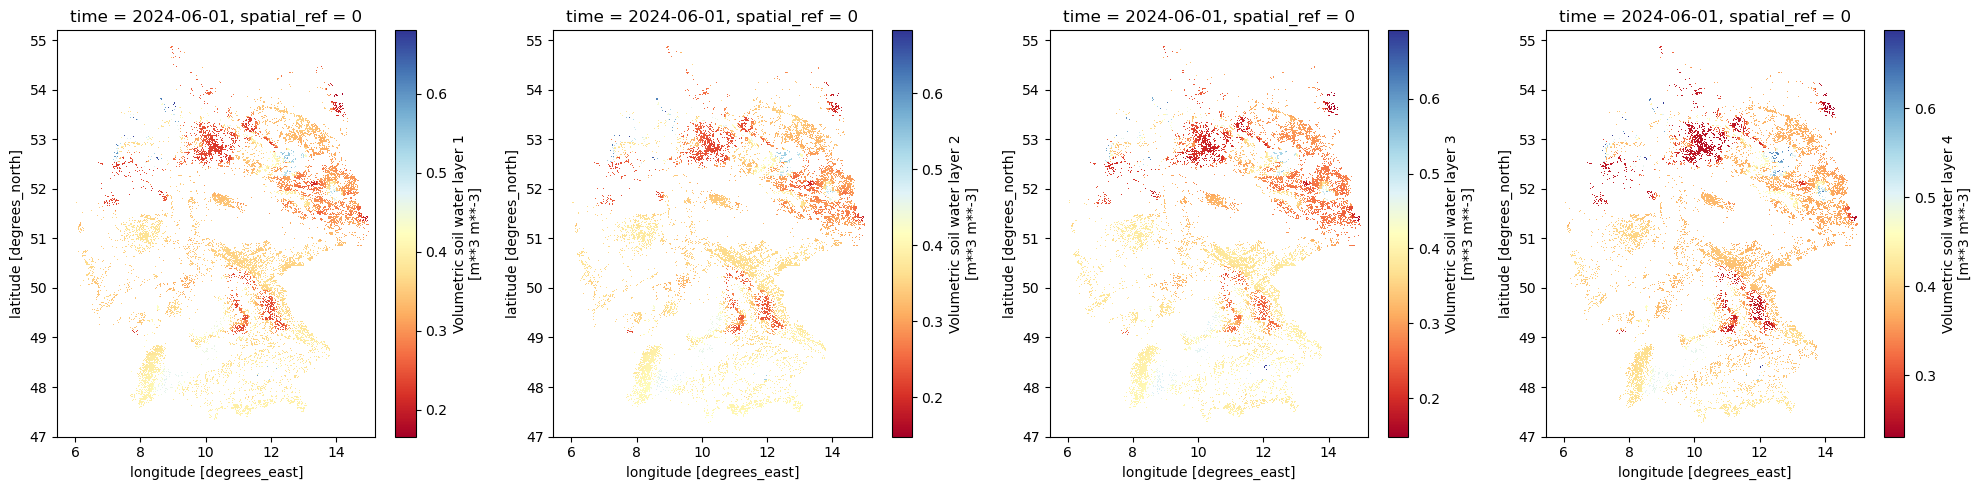

In [18]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
swvl1_NL.sel(time='2024-06-01').plot(ax=axs[0], cmap='RdYlBu')
swvl2_NL.sel(time='2024-06-01').plot(ax=axs[1], cmap='RdYlBu')
swvl3_NL.sel(time='2024-06-01').plot(ax=axs[2], cmap='RdYlBu')
swvl4_NL.sel(time='2024-06-01').plot(ax=axs[3], cmap='RdYlBu')
plt.tight_layout()